In [1]:
%load_ext autoreload
%autoreload 1
%aimport redditClient
%aimport RedditProcessing


# Function

In [2]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    """
    Compute the overall sentiment of the list of tokens in lTokens, using the countWordSentimentAnalysis approach.

    @param lTokens: List of tokens to calculate the overall sentiment for.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    
    @returns Sentiment score for lTokens.
    """
    # compute the sentiment 
    # count the number of positive words
    posNum = len([tok for tok in lTokens if tok in setPosWords])

    # count the number of negative words 
    negNum = len([tok for tok in lTokens if tok in setNegWords])

    # compute the sentiment value
    sentiment = posNum - negNum
    return sentiment

In [3]:
def countWordSentimentAnalysis(setPosWords, setNegWords, data):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param time: the string contain the key word for time_filter() function
    @param subreddit: list of submission (post from reddit)
    @param redditProcessor: RedditProcessing object, used to pre-process each tweet.

    @returns: list of reddit posts, in the format of [date, sentiment]
    """
    
    lSentiment = []
    for index, row in data.iterrows():
        postText = row['Content']
        postDate = row['Date']
        # pre-process the reddit post text
        lTokens = redditProcessor.process(postText)
        # compute sentiment
        sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
        # save the date and sentiment of each reddit post (used for time series)
        lSentiment.append([datetime.strptime(postDate, '%Y-%m-%d %H:%M:%S'), sentiment])

    return lSentiment


In [4]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [5]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

In [6]:
def TopicModeling(posts,topicNum,wordNumToDisplay,featureNum):
    '''
    @param topicNum: number of topics to discover
    @param wordNumToDisplay: maximum number of words to display per topic
    @param featureNum: number of features/words to used to describe our documents
    
    @param tfFeatureNames: name of the features
    @param ldaModel: LDA model
    '''
    # Count Vectorizer
    tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=lStopwords)
    tf = tfVectorizer.fit_transform(posts)
    # extract the names of the words
    tfFeatureNames = tfVectorizer.get_feature_names_out()

    # LDA MODEL
    # Run LDA
    ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

    return ldaModel,tfFeatureNames

In [7]:
def GensimPreprocess(text):
    custom_STOPWORDS = ["like", "lol", "http", "hes","say","dont", "in", "youre","im","thats", "say", "delete", "oh", "look","si", "nu", "ca", "sa", "la", "remove", "know", "didnt", "reddit", "se", "das", "hai","romanian","link", "comment", "need", "year", "bot", "karma", "sub", "ive", "und","der", "ich", "yes", "run"]
    concat_STOPWORDS = set(STOPWORDS).union(custom_STOPWORDS)
    #regex filter
    text = re.sub(r'http\S+', '', text)
    # Remove special characters (non-words) except for spaces
    text = re.sub(r'[^\w\s]', '', text)

    result = []
    lemmatizer = WordNetLemmatizer()  # Initialize the lemmatizer once outside the loop for efficiency
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in simple_preprocess(text)]
    
    # Filter out stop words from lemmatized tokens
    result = [token for token in lemmatized_tokens if token not in concat_STOPWORDS]
    return result


In [8]:
def GensimLDA(corpus, num_topics, dictionary, passes, workers):
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, workers=workers)
    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        topic_num, topic_terms = topic
        # Remove weights and display only terms
        terms_only = " + ".join([word.split('*')[1].strip().strip('"') for word in topic_terms.split('+')])
        print(f"Topic: {topic_num}\nWords: {terms_only}\n")
    return lda_model

In [9]:
def get_dominant_topic(doc_bow, lda_model):
    """Get the dominant topic for a given bag-of-words document."""
    topic_distribution = lda_model[doc_bow]
    # Sorting to get the most probable topic
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    dominant_topic = topic_distribution[0][0]
    return dominant_topic

In [10]:
def describe_topic(lda_model, topic_id, topn=10):
    """Return the top words for a given topic."""
    word_ids = [word_id for word_id, prob in lda_model.get_topic_terms(topic_id, topn=topn)]
    words = [dictionary[id] for id in word_ids]
    return " ".join(words)

# Main

In [11]:
import warnings
warnings.filterwarnings('ignore') #hide warning 

import sys
import string #stopword punct
from collections import Counter # freq counter 
import codecs # read pos & neg files
import re #regular exp
import pandas as pd # convert dataframe 
import pyLDAvis.lda_model # lda model 
from wordcloud import WordCloud #wordcould visualization
from sklearn.feature_extraction.text import CountVectorizer #lda
from sklearn.decomposition import LatentDirichletAllocation #lda

from datetime import datetime # convert time data to datetime object

from redditClient import redditClient # reddit client library
import praw # library used for receive reddit post.

import numpy as np  #number 
import math #math calculation for word count sentiment score calculation

import matplotlib.pyplot as plt # visualization tools

import nltk #stop word/ sentiment analysis / tokenization etc
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import networkx as nx

#the other preporcessing library we are using
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim
# we use lda model from gensim library instead
from gensim.models.ldamodel import LdaModel


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
# set up
posWordFile = 'positive-words.txt' # input file of set of postive words
negWordFile = 'negative-words.txt' # input file of set of negative words

red_data = pd.read_csv("Tate_all.csv")
you_data = pd.read_csv("Tate_youtube.csv")

# Topic Modelling

In [13]:
#process the content with the gensim preprocess function we defined at the top
processed_content = [GensimPreprocess(str(content)) for content in red_data.Content]

# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(processed_content)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in processed_content]


In [14]:
'''
# lda_model 
num_topics = 7
passes = 40 # More passes = more accurate, but it can over fit. 40-50 for large datasets
workers = 12 # How many processor cores to use
lda_model = GensimLDA(corpus, num_topics, dictionary, passes, workers)
'''
#load the lda model built from the code above
lda = LdaModel.load("Tate_all.LDA")

# Creating a Dominant Topic Column

In [15]:
# Get the dominant topic for each document
dominant_topics = [get_dominant_topic(doc, lda_model) for doc in corpus]

# Add dominant topic to the dataframe
red_data['Topic'] = dominant_topics

NameError: name 'lda_model' is not defined

In [ ]:
# call a function we built to generate topic description for each topics we got
topic_descriptions = [describe_topic(lda_model, i) for i in range(num_topics)]

# include the topic description in the 
red_data['Topic_description'] = [topic_descriptions[i] for i in dominant_topics]


"\ntopic_descriptions = [describe_topic(lda_model, i) for i in range(num_topics)]\nred_data['Topic_description'] = [topic_descriptions[i] for i in dominant_topics]\n\nred_data.head()\n"

In [ ]:
#this is where we save the topic and model built above
#red_data.to_csv('Tate_all_topic.csv')
#lda_model.save("Tate_all.LDA")


# Graph Model

In [ ]:
#graph model built here
G = nx.DiGraph()
edges = [(row['ParentID'], row['ID'], {'weight': row['Upvotes']}) for _, row in red_data.iterrows()]
G.add_edges_from(edges)

nodes = [(row['ID'], {'Date': row['Date'], 'Topic_description': row['Topic_description']}) for _, row in red_data.iterrows()]
G.add_nodes_from(nodes)

"\nimport networkx as nx\n\nG = nx.DiGraph()\nedges = [(row['ParentID'], row['ID'], {'weight': row['Upvotes']}) for _, row in red_data.iterrows()]\nG.add_edges_from(edges)\n\nnodes = [(row['ID'], {'Date': row['Date'], 'Topic_description': row['Topic_description']}) for _, row in red_data.iterrows()]\nG.add_nodes_from(nodes)\n"

In [ ]:
#save the graph 
#nx.write_graphml(G, "Tate_all_topic.graphml")

# data preprocessing

In [ ]:
#group the youtube comments data by the video name (considering a single video as a submission for reddit) 
video_name = you_data['VideoName'].unique()
# drop the column that isn't useful 
#you_data = you_data.drop(columns='Unnamed: 0')

#standardize the date data for youtube and reddit so easier for further processing
for i, x in enumerate(you_data['Date']):
    a = x.split('+')
    you_data.at[i, 'Date'] = a[0]

In [ ]:
you_data

,Unnamed: 0,ID,ParentID,Type,Content,Upvotes,Date,VideoName
0,0,UgzcO3bVC_-SqlfnIux4AaABAg,tgNGrT3B1ik,comment,This girl is 100% wrong,0,2023-10-04 13:41:28,HEATED Debate: Is Andrew Tate Good For Society?
1,1,UgyK1FqoMMcyoTnwI3F4AaABAg,tgNGrT3B1ik,comment,Not even Candace Owens couldn’t articulate tho...,0,2023-10-04 13:41:22,HEATED Debate: Is Andrew Tate Good For Society?
2,2,UgyfqLmMbxkgpmm1NXx4AaABAg,tgNGrT3B1ik,comment,Guys 100% right? She’s totally wrong.,0,2023-10-04 13:41:08,HEATED Debate: Is Andrew Tate Good For Society?
3,3,Ugw6q4S5KYcIOVJ93pJ4AaABAg,tgNGrT3B1ik,comment,Does she keep this same energy with the Kardas...,0,2023-10-04 13:41:02,HEATED Debate: Is Andrew Tate Good For Society?
4,4,UgymTqI0qab6pfv1P1l4AaABAg,tgNGrT3B1ik,comment,She’s spot on. Adam had TERRIBLE points and th...,0,2023-10-04 13:40:51,HEATED Debate: Is Andrew Tate Good For Society?
...,...,...,...,...,...,...,...,...
403408,403408,UgxbqJLgso1sRnWorbp4AaABAg,L7aYvcwfCTc,comment,Ty habibu,3,2023-09-21 07:08:14,ADIN ROSS AND ANDREW TATE FULL INTERVIEW 09/20...
403409,403409,UgwcUxEoiOOHOMnqTtV4AaABAg,L7aYvcwfCTc,comment,Thanks man,4,2023-09-21 07:02:01,ADIN ROSS AND ANDREW TATE FULL INTERVIEW 09/20...
403410,403410,UgzizNOTJMJC9Mih_Zt4AaABAg,L7aYvcwfCTc,comment,Thanksss broo,11,2023-09-21 06:57:26,ADIN ROSS AND ANDREW TATE FULL INTERVIEW 09/20...
403411,403411,Ugz5X3g-gnk3mNBhOQF4AaABAg,L7aYvcwfCTc,comment,Ur the man,9,2023-09-21 05:56:34,ADIN ROSS AND ANDREW TATE FULL INTERVIEW 09/20...


In [ ]:
#group the youtube data basedo on the video name
data_y=[]
for name in video_name:
    comments= you_data[you_data['VideoName']==name]
    data_y.append(comments)

In [ ]:
data_y[0]

,Unnamed: 0,ID,ParentID,Type,Content,Upvotes,Date,VideoName
0,0,UgzcO3bVC_-SqlfnIux4AaABAg,tgNGrT3B1ik,comment,This girl is 100% wrong,0,2023-10-04 13:41:28,HEATED Debate: Is Andrew Tate Good For Society?
1,1,UgyK1FqoMMcyoTnwI3F4AaABAg,tgNGrT3B1ik,comment,Not even Candace Owens couldn’t articulate tho...,0,2023-10-04 13:41:22,HEATED Debate: Is Andrew Tate Good For Society?
2,2,UgyfqLmMbxkgpmm1NXx4AaABAg,tgNGrT3B1ik,comment,Guys 100% right? She’s totally wrong.,0,2023-10-04 13:41:08,HEATED Debate: Is Andrew Tate Good For Society?
3,3,Ugw6q4S5KYcIOVJ93pJ4AaABAg,tgNGrT3B1ik,comment,Does she keep this same energy with the Kardas...,0,2023-10-04 13:41:02,HEATED Debate: Is Andrew Tate Good For Society?
4,4,UgymTqI0qab6pfv1P1l4AaABAg,tgNGrT3B1ik,comment,She’s spot on. Adam had TERRIBLE points and th...,0,2023-10-04 13:40:51,HEATED Debate: Is Andrew Tate Good For Society?
...,...,...,...,...,...,...,...,...
4711,4711,UgwD7ldDZyU_gTieLOx4AaABAg,tgNGrT3B1ik,comment,"old tate, definitely bad, new tate, i think good.",9,2023-10-04 00:51:20,HEATED Debate: Is Andrew Tate Good For Society?
4712,4712,UgwD7ldDZyU_gTieLOx4AaABAg.9vQmTzXMcrM9vQq0exS3F2,UgwD7ldDZyU_gTieLOx4AaABAg,reply,@Johnnielegslikessoggybreadwithchese LOL you t...,0,2023-10-04 01:22:17,HEATED Debate: Is Andrew Tate Good For Society?
4713,4713,UgwD7ldDZyU_gTieLOx4AaABAg.9vQmTzXMcrM9vQnRR3Jjln,UgwD7ldDZyU_gTieLOx4AaABAg,reply,@Nihar Patelgame ain’t free you gotta pay if y...,0,2023-10-04 00:59:43,HEATED Debate: Is Andrew Tate Good For Society?
4714,4714,UgwD7ldDZyU_gTieLOx4AaABAg.9vQmTzXMcrM9vQnEIQPPuJ,UgwD7ldDZyU_gTieLOx4AaABAg,reply,Finally someone with a brain,0,2023-10-04 00:57:55,HEATED Debate: Is Andrew Tate Good For Society?


In [ ]:
# text processing (tokenization, filtering, stemming)
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
# use stopwords from nltk and a few other twitter specific terms and emotiocons.
# we use the popular Porter stemmer
lPunct = list(string.punctuation)
custom_STOPWORDS = ["like", "lol", "http", "hes","say","dont", "in", "youre","im","thats", "say", "delete", "oh", "look","si", "nu", "ca", "sa", "la", "remove", "know", "didnt", "reddit", "se", "das", "hai","romanian","link", "comment", "need", "year", "bot", "karma", "sub", "ive", "und","der", "ich", "yes", "run"]
lStopwords = nltk.corpus.stopwords.words('english') + lPunct +  ['lol','wa','hi','<br>','⚡','ani','via',"it'","i'm","becaus",'thi','ha','defi','whi','...','','’','‘','.','—','</a>','<a>','']
fnl_stopwords = custom_STOPWORDS+lStopwords
tweetStemmer = nltk.stem.PorterStemmer()

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(tweetTokeniser,tweetStemmer,fnl_stopwords)

# load set of positive and negative words
lPosWords = []
lNegWords = []

with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())
setPosWords = set(lPosWords)

with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)


## Reddit Data

In [ ]:
red_data.head()
red_data.shape

(350410, 6)

In [ ]:
#text and sentiment analysis for reddit data
red_termFreqCounter = Counter()
lPosts = []

for i, x in enumerate(red_data['Content']):
    # Check if the content is not a string
    if not isinstance(x, str):
        # Convert to string or skip depending on your preference
        x = str(x)

    token = redditProcessor.process(x)
    red_termFreqCounter.update(token)
    
    sentiment_score = computeSentiment(token, setPosWords, setNegWords)
    if sentiment_score > 0:
        red_data.at[i, 'Sentiment'] = 'Positive'
    elif sentiment_score < 0:
        red_data.at[i, 'Sentiment'] = 'Negative'
    else:
        red_data.at[i, 'Sentiment'] = 'Neutral'
        
    lPosts.append(' '.join(token))


In [ ]:
red_data.shape

(350410, 7)

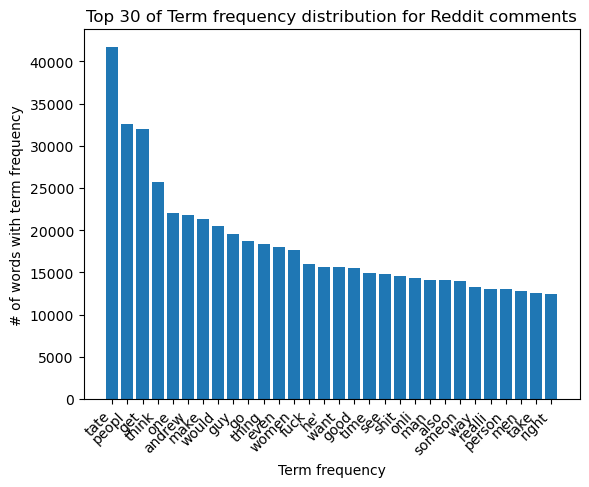

In [ ]:
# construct the x and y values
y = [count for tag, count in red_termFreqCounter.most_common(30)]
x = [tag for tag, count in red_termFreqCounter.most_common(30)]
#x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Top 30 of Term frequency distribution for Reddit comments")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# sentiment analysis

In [ ]:
#count word sentiment
cSentiment = []
cSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, red_data)

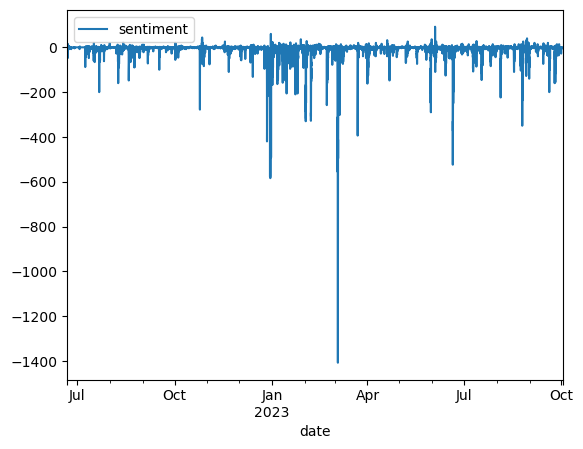

In [ ]:
# timeseries part
series = pd.DataFrame(cSentiment, columns=['date', 'sentiment'])
series.set_index('date', inplace=True)
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)
newSeries = series.resample('1H').sum()
#Overall Sentiment Time series Plot for Reddit User
newSeries.plot()
plt.show()

In [ ]:
# get the count of the each sentiment for basic word count sentiment
posCount=0
negCount=0
neuCount=0

for date,score in cSentiment:
    if score >0:
        posCount+=1
    elif score<0:
        negCount+=1
    else:
        neuCount+=1
        
print(posCount,negCount,neuCount)

61608 116702 172100


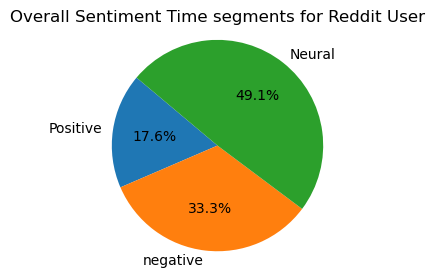

In [ ]:
# pie chart for overall sentiment 
categories = ['Positive', 'negative', 'Neural']
values = [posCount,negCount,neuCount]

plt.figure(figsize=(3, 3))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Overall Sentiment segments for Reddit User')
plt.axis('equal')

plt.show()

## Youtube Data

In [ ]:
red_data.shape

(350410, 7)

In [ ]:
you_data.shape

(403413, 8)

In [ ]:
#text and sentiment analysis for youtube data
you_termFreqCounter = Counter()
lPosts = []

for i, x in enumerate(you_data['Content']):
    # Check if the content is not a string
    if not isinstance(x, str):
        # Convert to string or skip depending on your preference
        x = str(x)

    token = redditProcessor.process(x)
    you_termFreqCounter.update(token)
    sentiment_score = computeSentiment(token, setPosWords, setNegWords)        
    lPosts.append(' '.join(token))


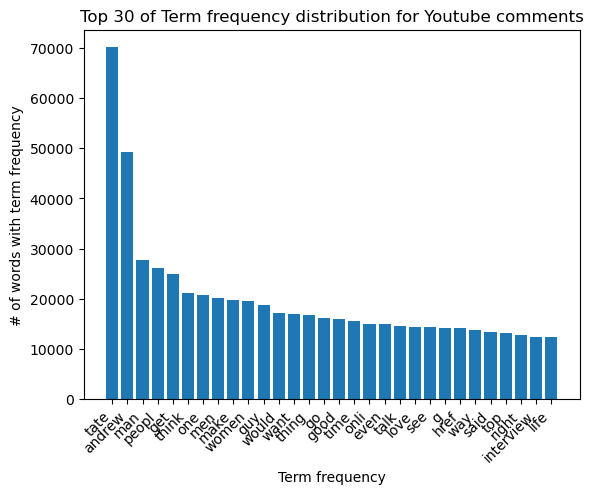

In [ ]:
# construct the x and y values
y = [count for tag, count in you_termFreqCounter.most_common(30)]
x = [tag for tag, count in you_termFreqCounter.most_common(30)]
#x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Top 30 of Term frequency distribution for Youtube comments")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#count word sentiment
cySentiment = []
cySentiment = countWordSentimentAnalysis(setPosWords, setNegWords, you_data)

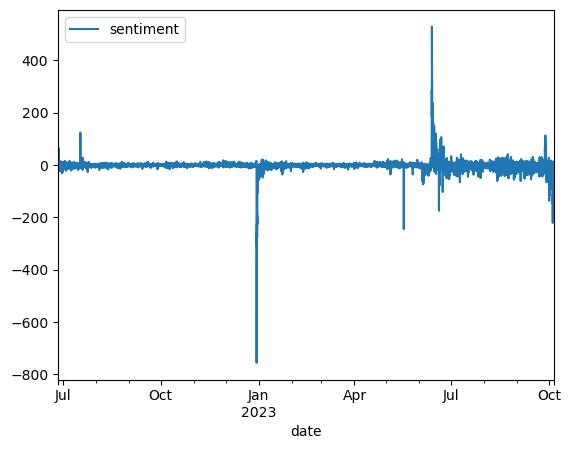

In [ ]:
# timeseries part
series = pd.DataFrame(cySentiment, columns=['date', 'sentiment'])
series.set_index('date', inplace=True)
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)
newSeries = series.resample('1H').sum()
#Overall Sentiment Time series Plot for Reddit User
newSeries.plot()
plt.show()

In [ ]:
# get the count of the each sentiment for basic word count sentiment
yposCount=0
ynegCount=0
yneuCount=0

for date,score in cySentiment:
    if score >0:
        yposCount+=1
    elif score<0:
        ynegCount+=1
    else:
        yneuCount+=1
        
print(yposCount,ynegCount,yneuCount)

94360 100936 208117


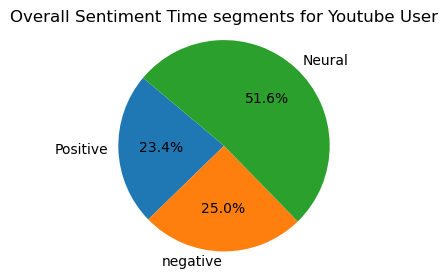

In [ ]:
# pie chart for overall sentiment 
values = [yposCount,ynegCount,yneuCount]

plt.figure(figsize=(3, 3))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Overall Sentiment segments for Youtube User')
plt.axis('equal')

plt.show()

# Topic modeling - Modified

In [ ]:
# LDA parameters
# number of topics to discover (default = 10)
topicNum = 5
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
featureNum = 2000

In [ ]:
#general word cloud for positive sentiment analysis
# lda, tfname =TopicModeling(lPosts,topicNum,wordNumToDisplay,featureNum)
display_topics(lda, tfname, wordNumToDisplay)
displayWordcloud(lda, tfname)